# Risk Assesement

In [1]:
%matplotlib inline

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import STL
from scipy.stats import ks_2samp
from Portfolio import selected_tickers

import yfinance as yf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import datetime as time

2025-09-05 15:44:37.396 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 15:44:37.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 15:44:37.409 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 15:44:37.510 
  command:

    streamlit run /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-09-05 15:44:37.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 15:44:37.512 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 15:44:37.513 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-05 15:44:37.515 Thread 'MainThread': missing ScriptRunContext! This

In [3]:
stock_data_june = pd.read_csv("stock_market_june2025.csv")
stock_data_53 = pd.read_csv("stock_data_july_2025.csv")

In [102]:
pd.set_option('display.max_rows', 100) 
stock_data_june['Ticker'].value_counts().gt(2).sum()

0

In [4]:
# Checking tickers that appear more than once
stock_data_53['Ticker'].value_counts().gt(1).sum()
# Checking tickers that appear more than twice
stock_data_53['Ticker'].value_counts().gt(2).sum()

# Filtering
valid_tickers = stock_data_53['Ticker'].value_counts()
valid_tickers = valid_tickers[valid_tickers > 2].index
sorted_stock_data = stock_data_53[stock_data_53['Ticker'].isin(valid_tickers)]

In [6]:
len(sorted_stock_data)

4346

In [7]:
# Sorting the df
sorted_stock_data["Date"] = pd.to_datetime(sorted_stock_data["Date"], dayfirst=True, format="mixed")
sorted_stock_data = sorted_stock_data.sort_values(['Ticker', 'Date'])


### Percentage Change

In [8]:
# Calculating percentage change
sorted_stock_data['Return'] = sorted_stock_data.groupby('Ticker')['Close Price'].pct_change()
# sorted_stock_data

### Volatility

In [10]:
# Volatility
volatility = sorted_stock_data.groupby('Ticker')['Return'].std()
volatility.dropna(inplace=True)
volatility.to_csv('volatility-by-ticker.csv')
volatility

### Value At Risk

In [14]:
# Value at Risk
Var_95_by_ticker = sorted_stock_data.groupby('Ticker')['Return'].apply(
    lambda x: np.percentile(x.dropna(), 5)
)
Var_95_by_ticker.to_csv('VaR-by-ticker.csv')
Var_95_by_ticker

### Conditional VaR

In [12]:
# Conditional VaR
CVaR_95_by_Ticker = sorted_stock_data.groupby('Ticker')['Return'].apply(
    lambda x: x[x <= np.percentile(x.dropna(), 5)].mean()
)
CVaR_95_by_Ticker.to_csv('CVaR-by-Ticker.csv')

### Drawdown

In [11]:
# Cumulative Return Calculation
sorted_stock_data['CumulativeReturn'] = (1 + sorted_stock_data['Return']).groupby(sorted_stock_data['Ticker']).cumprod()


In [14]:
# Running Maximum Calcualtion
sorted_stock_data['RunningMax'] = sorted_stock_data.groupby('Ticker')['CumulativeReturn'].cummax()

In [15]:
# Drawdown Calculation
sorted_stock_data['Drawdown'] = sorted_stock_data['CumulativeReturn'] / sorted_stock_data['RunningMax'] - 1
max_drawdown = sorted_stock_data.groupby('Ticker')['Drawdown'].min()
sorted_stock_data.to_csv('data-with-drawdown.csv')

In [16]:
stock_data = stock_data_june

In [20]:
stock_data_53['Date']= pd.to_datetime(stock_data_53['Date'])
stock_data_june['Date']= pd.to_datetime(stock_data_june['Date'], format='%d-%m-%Y')

filtered = stock_data_53[stock_data_53['Date'] <= '2025-06-30']
stock_data_june.reset_index(drop=True).equals(filtered.reset_index(drop=True))

False

In [21]:
stock_data_june['Ticker'].value_counts()

Ticker
OUF    2
XVD    2
CLL    2
GFF    2
TXP    2
      ..
JKX    1
OUV    1
KOM    1
LJX    1
UAA    1
Name: count, Length: 1691, dtype: int64

In [ ]:
filtered['Ticker'].value_counts()

# Time Series Analysis

# Scrapping

In [92]:
dataset_tickers = stock_data_53['Ticker'].unique().tolist()
dataset_tickers = [t.replace('.', '-') for t in dataset_tickers]
ten_year_data = yf.download(dataset_tickers, start='2014-06-01', end='2025-06-01', threads=False)[["Open","High","Low","Close", "Volume"]]


[*********************100%***********************]  82 of 82 completed


In [93]:
ten_year_data

Price             Open                                                  \
Ticker            AAPL        ABBV         ABT        ADBE         ADP   
Date                                                                     
2014-06-02   19.911316   34.500272   32.259504   64.540001   54.718784   
2014-06-03   19.738575   34.265744   31.985431   64.190002   54.217296   
2014-06-04   20.020623   34.177015   32.082151   64.099998   53.811959   
2014-06-05   20.295751   34.576320   32.049917   64.300003   54.127977   
2014-06-06   20.411962   35.064381   32.299787   65.989998   54.389040   
...                ...         ...         ...         ...         ...   
2025-05-23  193.450453  180.808341  131.091564  409.109985  317.483676   
2025-05-27  198.075209  182.692089  131.260807  412.760010  321.274721   
2025-05-28  200.362600  183.762828  132.505229  413.809998  325.692655   
2025-05-29  203.349217  181.889025  131.141342  414.000000  322.588164   
2025-05-30  199.143981  183.415831  132.286209  414.140015  323.563294   

Price                                                                   ...  \
Ticker             AMD        AMGN         AMT        AMZN        AVGO  ...   
Date                                                                    ...   
2014-06-02    4.030000   84.870691   69.317424   15.629500    5.337484  ...   
2014-06-03    3.960000   84.674386   68.327968   15.287500    5.346476  ...   
2014-06-04    3.930000   85.437852   68.583034   15.342500    5.341230  ...   
2014-06-05    4.040000   86.775781   68.892260   15.405000    5.359970  ...   
2014-06-06    4.090000   86.397655   69.433378   16.250000    5.417685  ...   
...                ...         ...         ...         ...         ...  ...   
2025-05-23  108.089996  267.311488  211.455752  198.899994  226.407103  ...   
2025-05-27  113.180000  271.497534  209.372170  203.089996  232.323178  ...   
2025-05-28  114.919998  276.774704  211.336695  205.919998  236.593122  ...   
2025-05-29  115.489998  276.973118  210.007173  208.029999  245.332560  ...   
2025-05-30  111.580002  280.335807  211.455765  204.839996  240.653577  ...   

Price           Volume                                                 \
Ticker            UBER       UNH      UNP      UPS         V     VRTX   
Date                                                                    
2014-06-02         NaN   1986400  2625600  2914100   6364000  1173000   
2014-06-03         NaN   2841100  2845600  2319200   9011600   975500   
2014-06-04         NaN   3552900  2354800  2822100  12589600  1581900   
2014-06-05         NaN   3453700  3489200  2514900   6597600  1397700   
2014-06-06         NaN   3286600  4104800  2103700  10002400  1185200   
...                ...       ...      ...      ...       ...      ...   
2025-05-23  17929700.0  16873600  3227900  3318500   5345900  1427300   
2025-05-27  17446900.0  20144600  2613300  6117400   6316000  2048300   
2025-05-28  13810300.0  16114200  3073200  3816500   3299000  1209500   
2025-05-29  38116300.0  16221100  2980600  4593900   4590400   882500   
2025-05-30  29050900.0  16309300  4179600  6763200   8726900  2581700   

Price                                              
Ticker            VZ       WMT       XOM      ZTS  
Date                                               
2014-06-02  14364600  13171200   7761300  3561300  
2014-06-03  19683700  21640800   9384200  3323000  
2014-06-04  12696000  18599700   7148800  3349900  
2014-06-05   9855300  14087400  12296100  2784700  
2014-06-06  13917800  12566700   9340900  2524200  
...              ...       ...       ...      ...  
2025-05-23  12393400  13668600  12061600  2732200  
2025-05-27  12873700  17180900  13043600  2323100  
2025-05-28  12783000  11220100  14292400  1723700  
2025-05-29   9960400  14338000  13825300  2450400  
2025-05-30  26569500  29980100  28645800  5467800  

[2767 rows x 410 columns]

#### There are missing values. These values are refilled by forward fill

In [95]:
missing_days = ten_year_data.index.to_series().diff().dt.days.value_counts()
missing_days

Date
1.0    2166
3.0     497
4.0      76
2.0      27
Name: count, dtype: int64

In [118]:
(ten_year_data.isnull() == True).any().any()

True

In [119]:
ten_year_data.shape

(2767, 410)

In [120]:
ten_year_data.dropna(inplace=True)

In [122]:
ten_year_data.shape

(1523, 410)

In [123]:
date_without_missing = pd.date_range(start=ten_year_data.index.min(), end=ten_year_data.index.max())
ten_year_data_fill = ten_year_data.reindex(date_without_missing).ffill()

In [126]:
ten_year_data_fill.shape

(2213, 410)

In [134]:
(ten_year_data_fill.isnull() == True).any().any()

False

In [138]:
ten_year_data_fill['Close']

Ticker,AAPL,ABBV,ABT,ADBE,ADP,AMD,AMGN,AMT,AMZN,AVGO,...,UBER,UNH,UNP,UPS,V,VRTX,VZ,WMT,XOM,ZTS
2019-05-10,47.299324,59.049660,68.537033,278.480011,141.207718,27.959999,140.719879,166.707596,94.499001,25.500360,...,41.570000,218.176804,152.317123,78.553909,153.627365,168.850006,40.257416,30.988604,57.046558,97.310600
2019-05-11,47.299324,59.049660,68.537033,278.480011,141.207718,27.959999,140.719879,166.707596,94.499001,25.500360,...,41.570000,218.176804,152.317123,78.553909,153.627365,168.850006,40.257416,30.988604,57.046558,97.310600
2019-05-12,47.299324,59.049660,68.537033,278.480011,141.207718,27.959999,140.719879,166.707596,94.499001,25.500360,...,41.570000,218.176804,152.317123,78.553909,153.627365,168.850006,40.257416,30.988604,57.046558,97.310600
2019-05-13,44.550323,58.607464,67.685356,267.700012,137.901810,26.240000,137.239746,167.747101,91.134003,24.612764,...,37.099998,217.233673,148.741226,77.554726,150.396271,164.610001,40.144222,30.374355,56.413200,96.416374
2019-05-14,45.255558,59.804470,68.160484,271.859985,138.997940,27.320000,137.411697,168.761002,92.005997,25.335936,...,39.959999,214.404358,151.078979,77.874779,153.149384,166.720001,40.002754,30.495991,56.487713,96.321228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26,195.048645,181.690720,130.713272,407.690002,319.493622,110.309998,269.473938,210.205597,200.990005,228.182922,...,87.750000,293.486603,219.402191,93.602295,352.919006,436.000000,42.630703,96.115509,102.080101,162.038177
2025-05-27,199.983047,184.129669,132.345932,413.100006,324.090637,114.559998,277.201263,212.031235,206.020004,235.096649,...,89.000000,292.920593,221.614883,95.741890,358.668884,446.000000,42.807838,97.352623,102.565582,165.705902
2025-05-28,200.192795,181.522171,131.430054,412.230011,322.528473,112.860001,276.159698,210.800919,204.720001,238.867767,...,88.260002,296.008667,219.471329,94.946899,359.098145,445.100006,42.443726,97.013412,101.168587,164.848770
2025-05-29,199.723328,184.030518,132.256348,413.359985,322.508545,113.029999,281.258362,212.041168,205.699997,241.401810,...,84.300003,296.068268,219.797318,96.281693,361.763428,447.089996,42.640545,96.873741,101.743240,166.582977


## Returns

In [167]:
ten_year_returns = ten_year_data_fill['Close'].pct_change()


## Moving Averages

In [194]:
mo_a_5 = ten_year_returns.rolling(5).mean().dropna()
mo_a_5.columns = pd.MultiIndex.from_product([['MA_5'], mo_a_5.columns])
mo_a_10 = ten_year_returns.rolling(10).mean().dropna()
mo_a_10.columns = pd.MultiIndex.from_product([['MA_10'], mo_a_10.columns])
mo_a_20 = ten_year_returns.rolling(20).mean().dropna()
mo_a_20.columns = pd.MultiIndex.from_product([['MA_20'], mo_a_20.columns])
mo_a_50 = ten_year_returns.rolling(50).mean().dropna()
mo_a_50.columns = pd.MultiIndex.from_product([['MA_50'], mo_a_50.columns])
mo_a_100 = ten_year_returns.rolling(100).mean().dropna()
mo_a_100.columns = pd.MultiIndex.from_product([['MA_100'], mo_a_100.columns])
mo_a_200 = ten_year_returns.rolling(200).mean().dropna()
mo_a_200.columns = pd.MultiIndex.from_product([['MA_200'], mo_a_200.columns])

In [195]:
moving_averages = pd.concat([
    mo_a_5,
    mo_a_10,
    mo_a_20,
    mo_a_50,
    mo_a_100,
    mo_a_200
], axis=1)

## Volatility

In [196]:
vol_21 = ten_year_returns.rolling(21).std()
vol_63 = ten_year_returns.rolling(63).std()
vol_252 = ten_year_returns.rolling(252).std()

## Market Index

In [197]:
market_index = yf.download('^GSPC', start='2014-06-01', end='2025-06-01')

[*********************100%***********************]  1 of 1 completed


In [204]:
market_index_return = market_index['Close'].pct_change().dropna()

## Classical Decomposition 

In [8]:
decomposition = {}
for ticker in three_year_data_return.columns:
    series = three_year_data_return[ticker]
    decomposition[ticker] = seasonal_decompose(series, model='additive', period=21)

In [10]:
trend = decomposition["VZ"].trend
seasonsal = decomposition["VZ"].seasonal
residual = decomposition["VZ"].resid

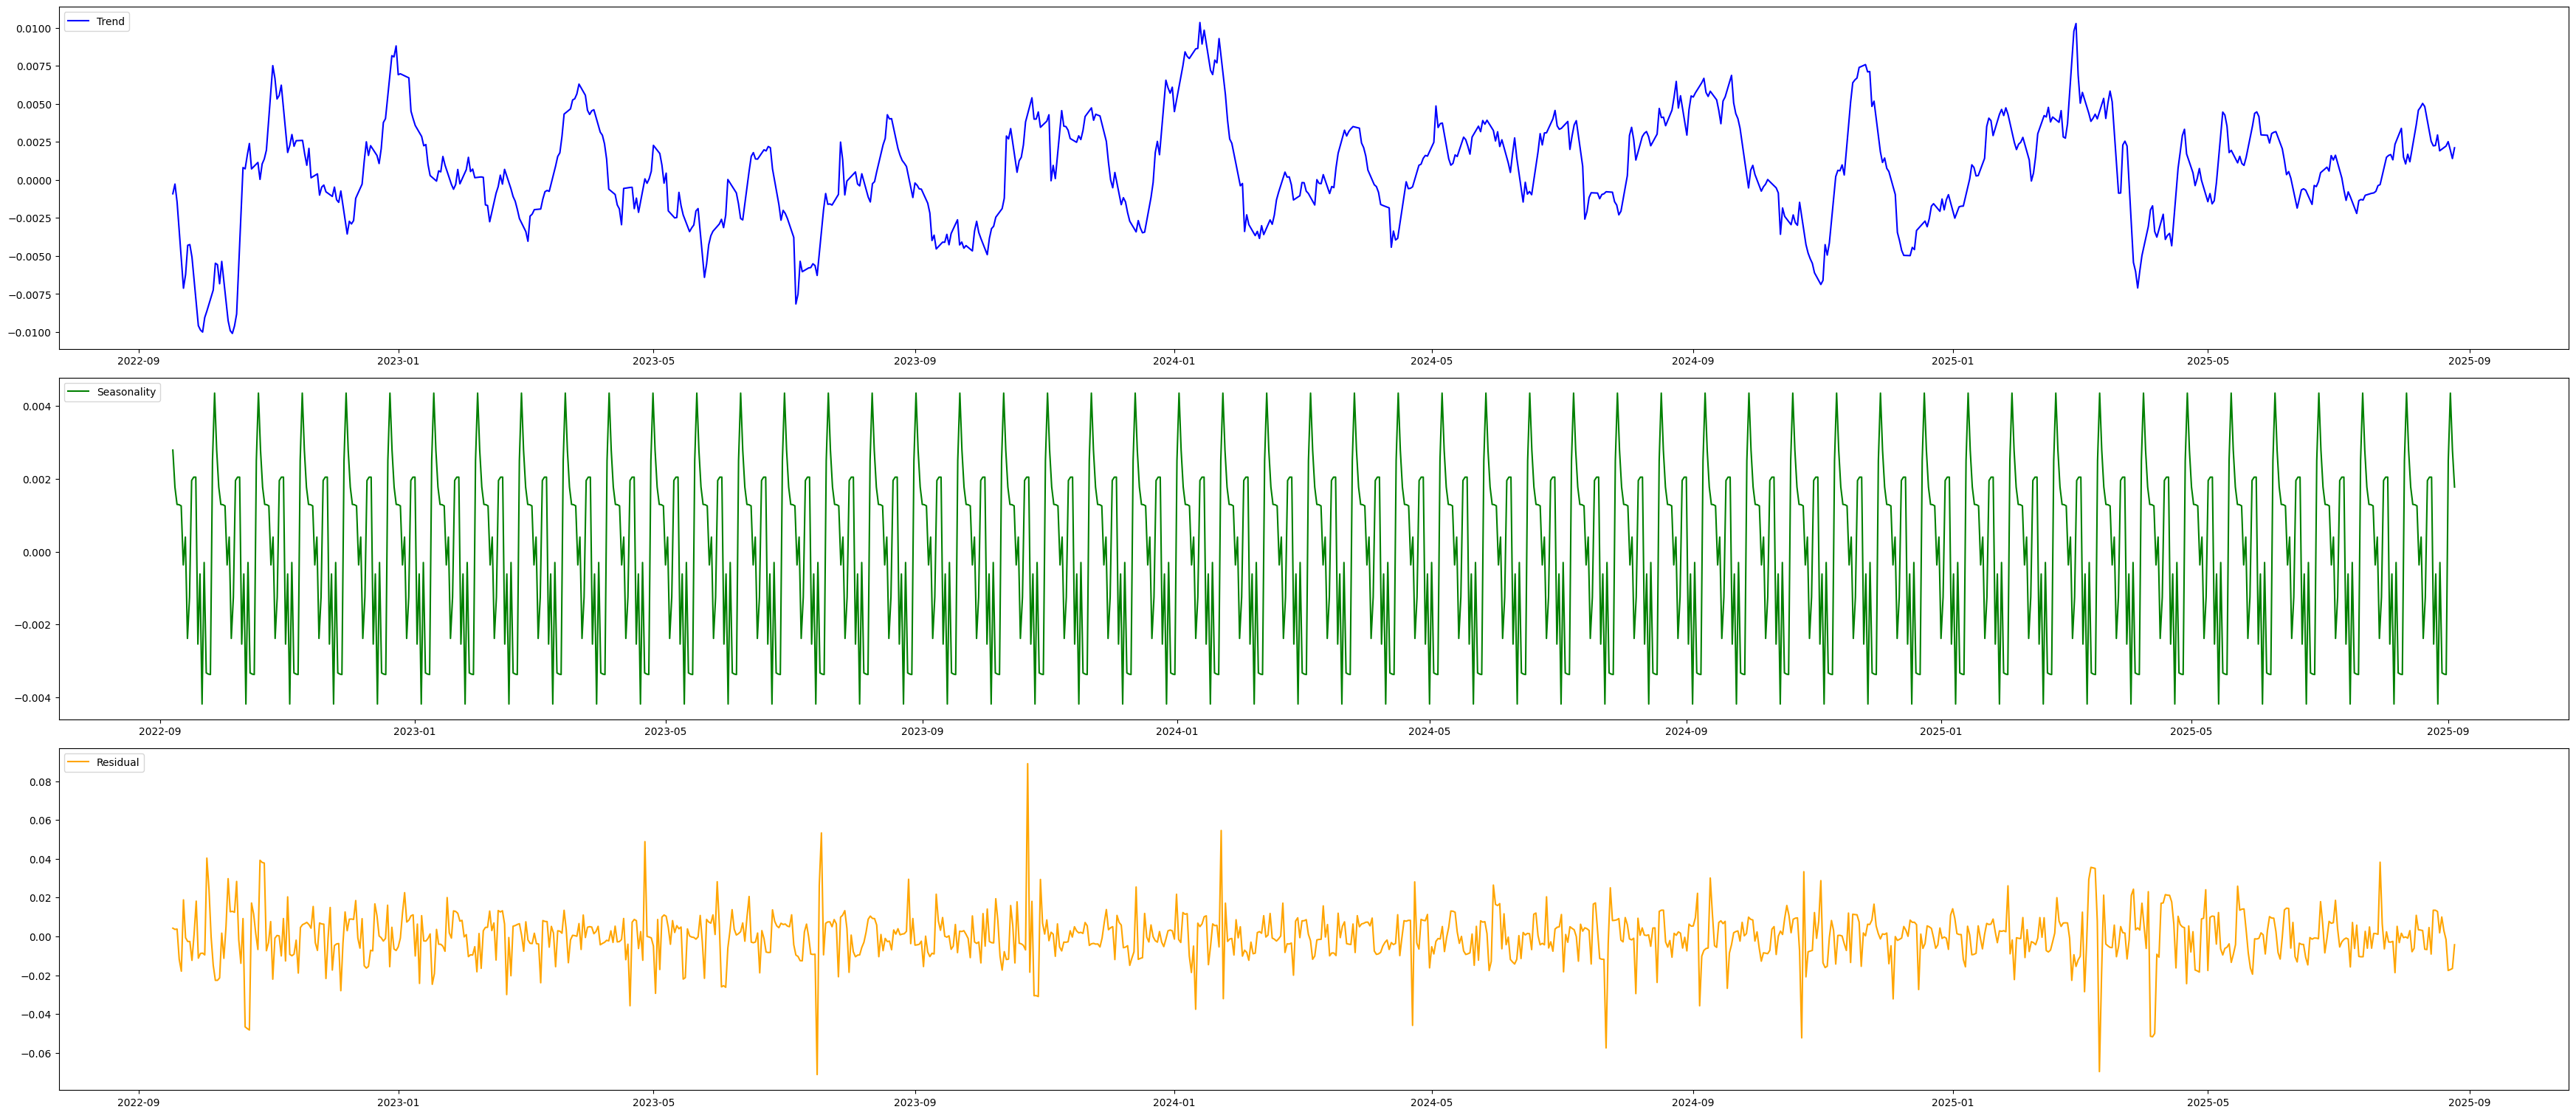

In [11]:
plt.figure(figsize=(35,20))
plt.subplot(411)
plt.plot(three_year_data_return.index, trend, label = "Trend", color= "blue")
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(three_year_data_return.index, seasonsal, label = "Seasonality", color= "green")
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(three_year_data_return.index, residual, label = "Residual", color= "orange")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

### STL Decomposition

In [38]:
stl_decomp = STL(daily_avg["Close Price"], period=7).fit()

NameError: name 'daily_avg' is not defined

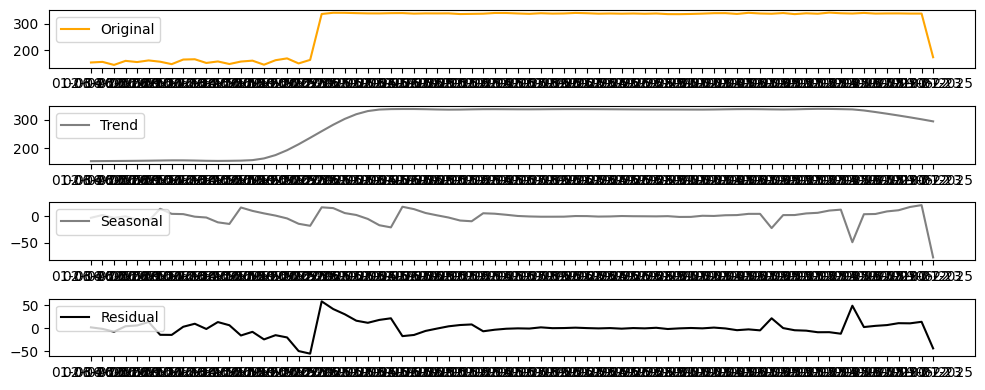

In [73]:
plt.figure(figsize=(10, 4))
plt.subplot(411)
plt.plot(daily_avg["Date"] ,stl_decomp.observed, label="Original", color="orange")
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(daily_avg["Date"] ,stl_decomp.trend, label="Trend", color="grey")
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(daily_avg["Date"], stl_decomp.seasonal, label="Seasonal", color="grey")
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(daily_avg["Date"], stl_decomp.resid, label="Residual", color="black")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

### Checking Stationarity
#### Performing Adf Test

In [74]:
adf_test = adfuller(daily_avg["Close Price"])
print(f"ADF Statistics: {round(adf_test[0], 3)}")
print(f"p-value: {round(adf_test[1], 3)}")
print("Critical Values")
for key, value in adf_test[4].items():
    print(f"{key}: {round(value, 3)}")


ADF Statistics: -1.634
p-value: 0.466
Critical Values
1%: -3.523
5%: -2.902
10%: -2.588


#### Performing KPSS Test

In [75]:
kpss_test = kpss(daily_avg["Close Price"], regression="ct")
print(f"KPSS Statistics: {round(kpss_test[0], 2)}")
print(f"p-value: {kpss_test[1]}")
for key, value in kpss_test[3].items():
    print(f"{key}: {value}")

KPSS Statistics: 0.26
p-value: 0.01
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216


#### Performing KS Test to check strict stationarity

In [76]:
def ks_test_stationarity(series):
    split = len(series) //2
    first_half = series[:split]
    second_half = series[split:]
    stat, p_value  = ks_2samp(first_half, second_half)
    return stat, p_value

ks_stat, ks_p_value = ks_test_stationarity(daily_avg["Close Price"])
print(ks_stat, ks_p_value)

0.5405405405405406 2.6284010564309513e-05


#### Conclusion: 
#### There is a conflict between the adf and kpss tests because the provided data is of 21 days which is not suitable for either of the tests to provide accurate results. Thereby, stationarity of data remains ambiguous